# Speech Emotion Recognition - Time Distributed ConvNet

A project for the French Employment Agency

Telecom ParisTech 2018-2019

## I. Context
In this project I build a prevision model using deep learning combining **CNN**  and  **LSTM**  to detect a person’s emotions (HAPPY, SAD, FEAR, ANGRY, DISGUST, SURPRISE, NEUTRAL) just by their voice. 

### Audio features:
- **Log-mel-spectrogram**: the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency


### Data:
- **RAVDESS**: The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes *calm*, *happy*, *sad*, *angry*, *fearful*, *surprise*, and *disgust* expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. (https://zenodo.org/record/1188976#.XA48aC17Q1J)

## II. General Imports

In [1]:
### General imports ###
import os
from glob import glob
import pickle
import numpy as np

### Plot imports ###
from IPython.display import Image
import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Connect Colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## III. Import datas

In [0]:
# RAVDESS mel-Spectrogram
X_train = pickle.load(open('drive/My Drive/SpeechEmotionRecognition/DIS/[RAVDESS][MEL_SPECT][X_train].p', 'rb'))
y_train = pickle.load(open('drive/My Drive/SpeechEmotionRecognition/DIS/[RAVDESS][MEL_SPECT][y_train].p', 'rb'))
y_test = pickle.load(open('drive/My Drive/SpeechEmotionRecognition/DIS/[RAVDESS][MEL_SPECT][y_test].p', 'rb'))
X_test = pickle.load(open('drive/My Drive/SpeechEmotionRecognition/DIS/[RAVDESS][MEL_SPECT][X_test].p', 'rb'))

## IV. Encode label

In [0]:
# Encode Label from categorical to numerical
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

## V. Reshape train and test set

In [0]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

## VI. Time Distributed ConvNet model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


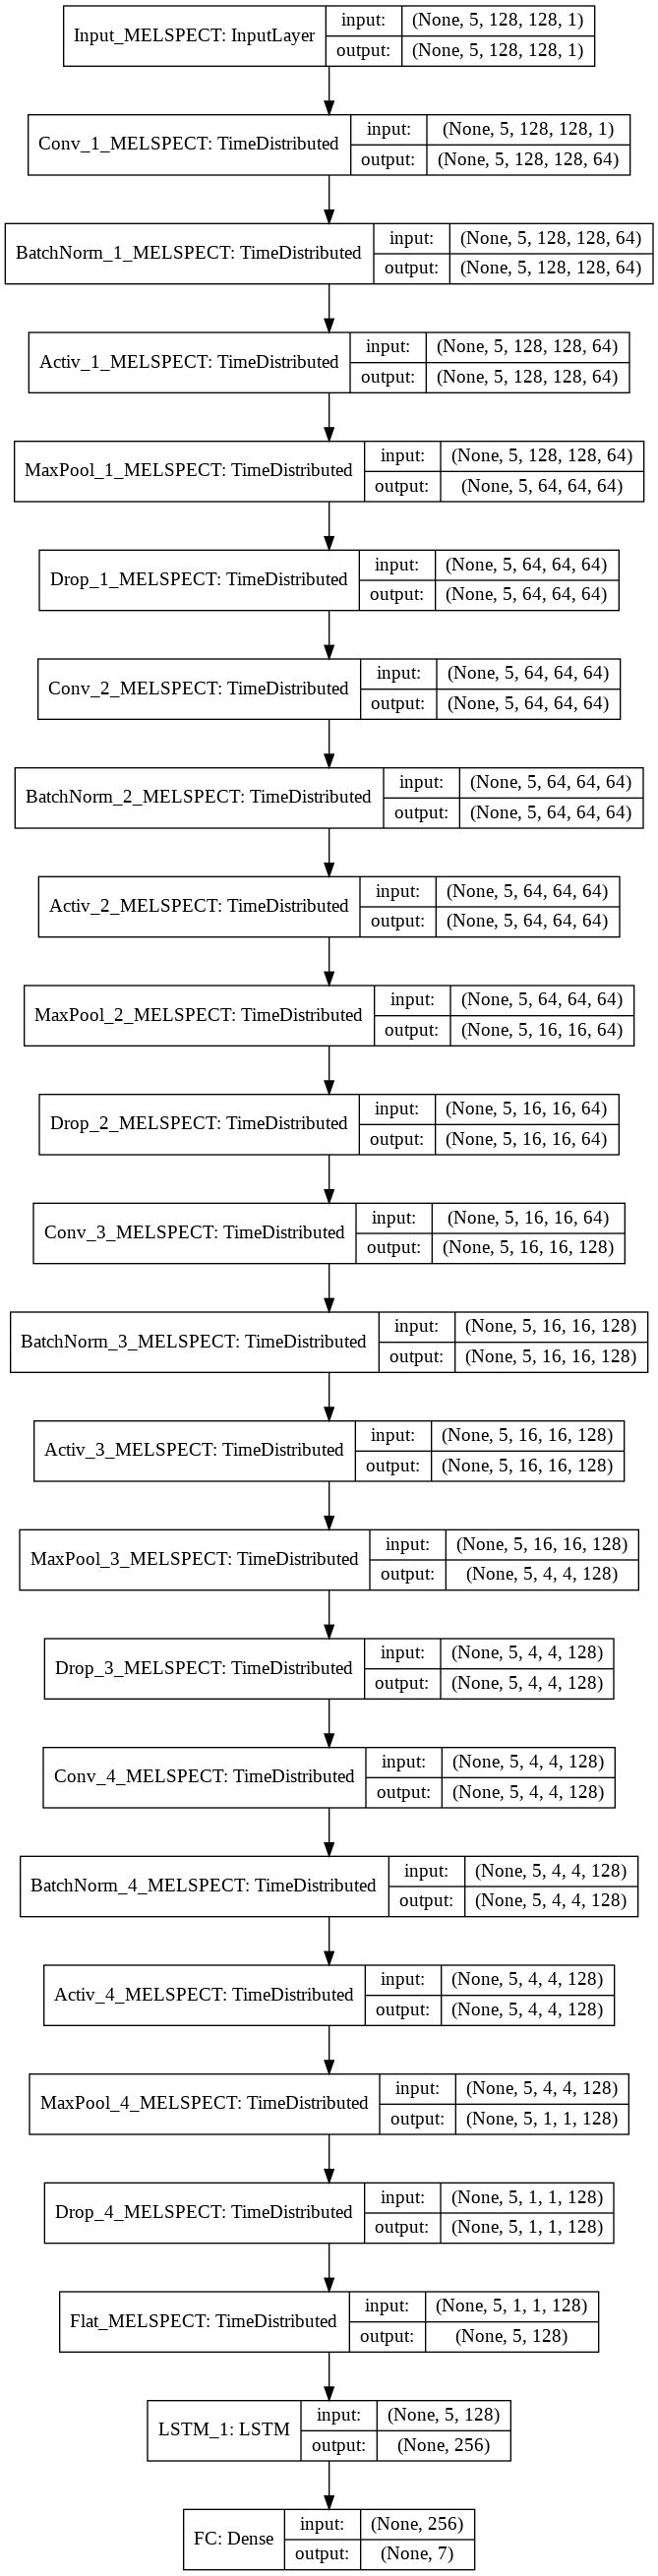

In [6]:
K.clear_session()

# Define two sets of inputs: MFCC and FBANK
input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                      
                               
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [7]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('drive/My Drive/SpeechEmotionRecognition/[CNN-LSTM]Model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Train on 3225 samples, validate on 269 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3225/3225 [==============================] - 37s 11ms/sample - loss: 1.9524 - acc: 0.1696 - val_loss: 2.1361 - val_acc: 0.1450
Epoch 2/100
3225/3225 [==============================] - 30s 9ms/sample - loss: 1.8779 - acc: 0.2214 - val_loss: 2.1104 - val_acc: 0.1487
Epoch 3/100
3225/3225 [==============================] - 29s 9ms/sample - loss: 1.8024 - acc: 0.2766 - val_loss: 1.8661 - val_acc: 0.2193
Epoch 4/100
3225/3225 [==============================] - 29s 9ms/sample - loss: 1.7169 - acc: 0.3104 - val_loss: 1.7818 - val_acc: 0.2788
Epoch 5/100
3225/3225 [==============================] - 29s 9ms/sample - loss: 1.6603 - acc: 0.3265 - val_loss: 1.6949 - val_acc: 0.3383
Epoch 6/100
3225/3225 [==============================] - 29s 9ms/sample - loss: 1.6419 - acc: 0.3417 - val_loss: 1.6796 - val_acc: 0.3383
Epoch 7/100
3225/3225 [==============================] - 29s 9ms/sample - lo

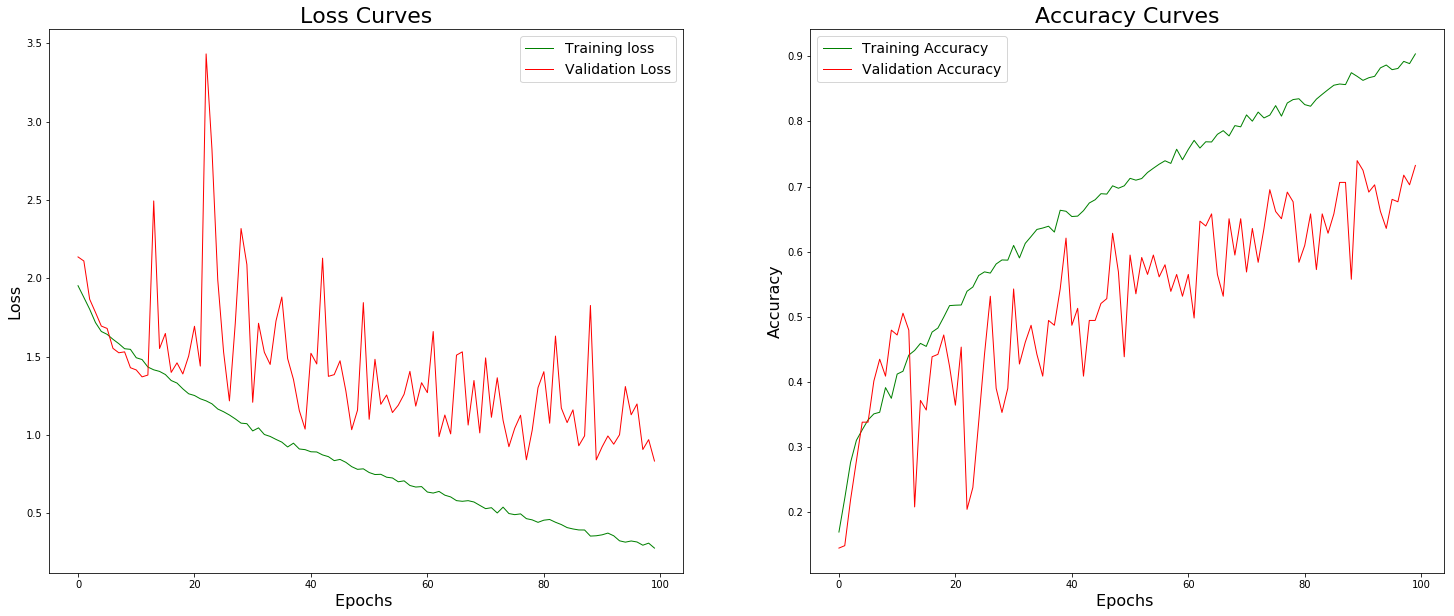

In [8]:
# Loss Curves
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],'-g',linewidth=1.0)
plt.plot(history.history['val_loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=22)
 
# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'],'-g',linewidth=1.0)
plt.plot(history.history['val_acc'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=22)
plt.show()

## VII. Save model

In [0]:
model.save('drive/My Drive/SpeechEmotionRecognition/[CNN-LSTM]M.h5')
model.save_weights('drive/My Drive/SpeechEmotionRecognition/[CNN-LSTM]W.h5')